In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

def cauchy(r, A, dr, r0):
    '''cauchy function'''
    r = np.array(r) - r0
    return A / (1 + r * r / dr**2)

def gauss(x, A, dx, x0):
    '''gauss function'''
    x = x - x0
    return A * np.exp(-(x * x / 2 / dx**2))

def imshow(image, title = None):
    '''plotting an image from a 2D array'''
    width = image.shape[1]
    height = image.shape[0]
    wscale = 16 / width
    hscale = 12 / height
    scale = min(wscale, hscale)
    plt.figure(figsize = (width * scale, height * scale))
    plt.axis('off')
    plt.imshow(image, cmap = 'gray')
    if title != None:
        plt.savefig(title + '.pdf')
        plt.title(title, fontsize = 20)
    return

def plot(X, Y, label = None, title = None, vlines = None):
    '''plotting function(s)'''
    X = np.array(X)
    Y = np.array(Y)
    plt.figure(figsize = (16, 12))
    Xdim = len(X.shape)
    
    if Xdim == 1:
        if label is None:
            label = ''
        plt.plot(X, Y, label = label)
    else:
        if label is None:
            label = np.zeros(X.shape[0], dtype = str)
        for i in range(X.shape[0]):
            plt.plot(X[i, :], Y[i, :], label = label[i])
    
    if not (vlines is None):
        for i in vlines:
            plt.vlines(i, 0, 255)
            
    if not (label is None):
        plt.legend(fontsize = 20)
        
    if title != None:
        plt.savefig(title + '.png', dpi = 100)
        plt.title(title, fontsize = 20)
    return

In [2]:
Ni = mpimg.imread('data/Ni_Calibration.tif')

inverted = 255-Ni

#kontraszt növelése
imarray = (inverted/255)**7 * 255
#zaj levágása
imarray = imarray * (imarray > 1)

#kép méretei
xlim = imarray.shape[0]
ylim = imarray.shape[1]

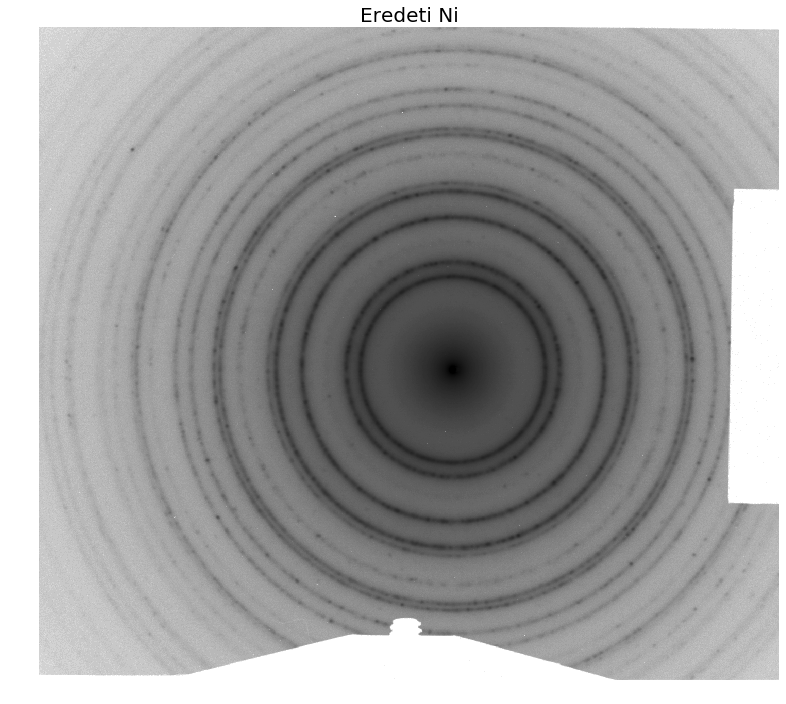

In [3]:
#eredeti kép
imshow(Ni, 'Eredeti Ni')

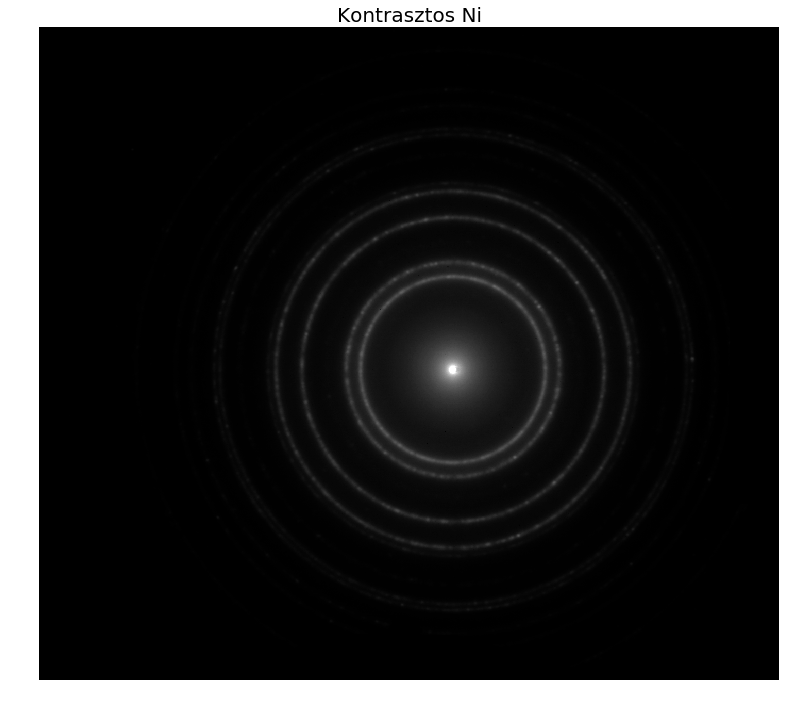

In [4]:
#invertált, kontrasztos kép
imshow(imarray, 'Kontrasztos Ni')

A módosított kép középpontját határoztam meg a következő kóddal. A pixelek intenzitásával súlyozott koordináták átlagát számoltam ki.

In [5]:
#a módosított kép súlypontjának meghatározása
#furcsa int overflow prolémákba ütköztem először, ezért
#a for ciklus a kép középpontjához képesti koordinátákkal
#számol
total = 0 #pixel intenzitás összeg
X = 0.0 #súlyozott összeg
Y = 0.0 #súlyozott összeg
for x in range(xlim):
    weight = np.sum(imarray[x, :])
    total += weight
    X += weight * (x - xlim/2)
    Y += np.sum(imarray[x, :] * np.linspace(-ylim/2, ylim/2-1, ylim))

x0 = int(X/total + xlim/2 + 0.5)
y0 = int(Y/total + ylim/2 + 0.5)

print(x0, y0)

total = 0 #pixel intenzitás összeg
X = 0.0 #súlyozott összeg
Y = 0.0 #súlyozott összeg
Rlim = 25
for x in range(xlim):
    mask = ((np.linspace(-ylim/2, ylim/2-1, ylim) - y0 + ylim/2 + 0.5)**2 + (x - x0 + 0.5)**2) < Rlim**2
    weight = np.sum(imarray[x, :] * mask)
    total += weight
    X += weight * (x - xlim/2)
    Y += np.sum(imarray[x, :] * np.linspace(-ylim/2, ylim/2-1, ylim) * mask)

print(total)

x0 = int(X/total + xlim/2 + 0.5)
y0 = int(Y/total + ylim/2 + 0.5)

print(x0, y0)

660 799
301843.69483656005
661 800


Itt a kiszámított középpontot ábrázolom ellenőrzés képpen.

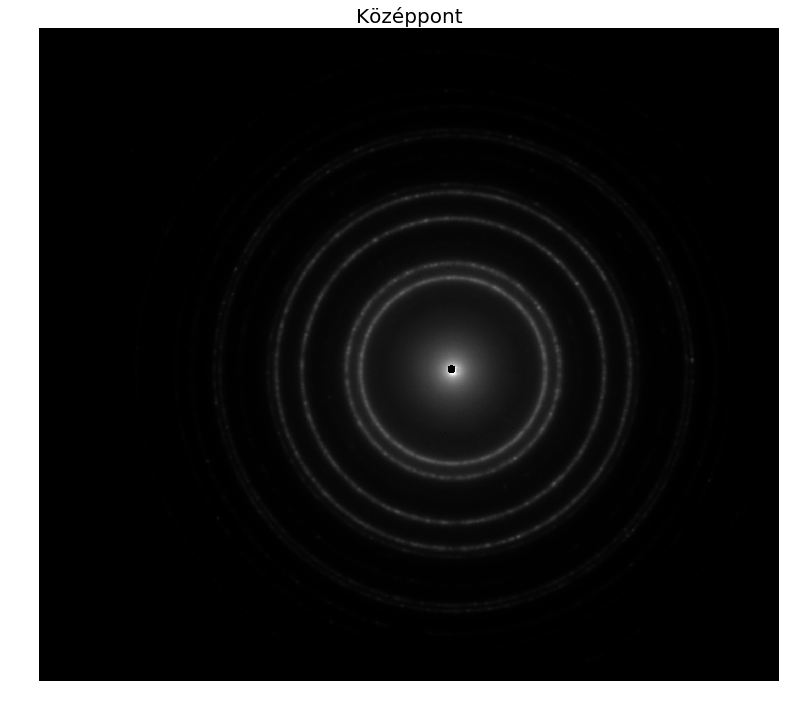

In [6]:
r = 8
center = np.copy(imarray)
for x in range(xlim):
    mask = (x-x0)**2 + (np.linspace(0, ylim-1, ylim) - y0)**2 < r**2
    center[x, mask] = 0
    
imshow(center, 'Középpont')

Látszik, hogy a középpont egy kicsit rossz helyen van. Ennek az oka az lehet, hogy az intenzitásnak van egy szisztematikus hibája. Úgy lehetne kiküszöbölni, hogy súlyozott átlag helyett valamiféle alak felismerő kódot használok a gyűrűk keresésére, ami jóval bonyolultabb lenne.


A következő kód az $I(r)$ függvvényt számítja ki a kontrasztos képből. A középponttól $r$ távolságban egy $2dr$ vastagságú gyűrűn kiszámítja a pixelek intenzitásána összegét, majd ezt az összeget elosztja a pixelek számával. A végredményt az $intensity$ tömbben tárolja.

In [7]:
Rrange = 600 #in pixels
dr = 3 #bin méret / 2
intensity = np.zeros(Rrange)
for r in range(Rrange):
    if r < 1:
        intensity[0] = 255
        continue
    A = 0
    y = np.linspace(0, ylim-1, ylim)
    for x in range(xlim):
        mask = np.abs((x - x0)**2 + (y - y0)**2 - r**2) < dr
        A += np.sum(mask)
        intensity[r] += np.sum(imarray[x, mask])
    intensity[r] /= A

A következő kódrészlet ezt az $I(r)$ függvényt ábrázolja. A cél a diffrakciós csúcsok helyének a meghatározása, ezért érdemes a fő elektronnyaláb intenzitását leválasztani, hogy csak a diffrakció által okozott intenzitással számolhassak. Egy Cauchy függvényt viszonylag pontosan lehetett illeszteni az elektronnyaláb szélére, ezért a későbbi számolások során ezt a függvényt levontam az $I(r)$ függvényből a számolás során.

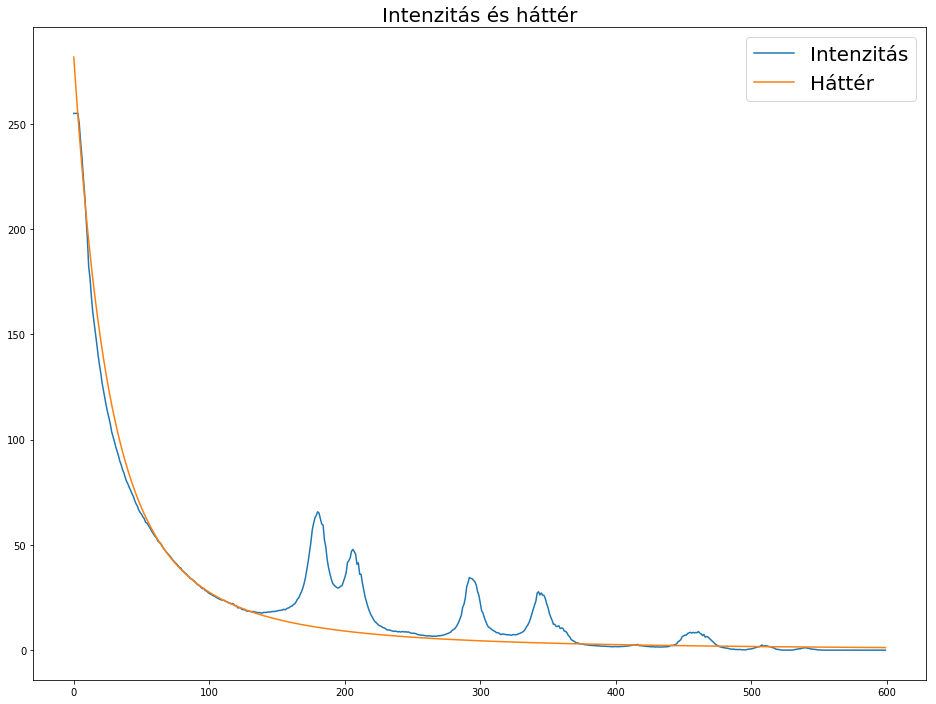

In [8]:
r = np.array(range(Rrange))
popt1, pcov1 = curve_fit(cauchy, r[60:140], intensity[60:140], [300, 60, 10])
plot([r, r], [intensity, cauchy(r, *popt1)],
     ['Intenzitás', 'Háttér'], 'Intenzitás és háttér')

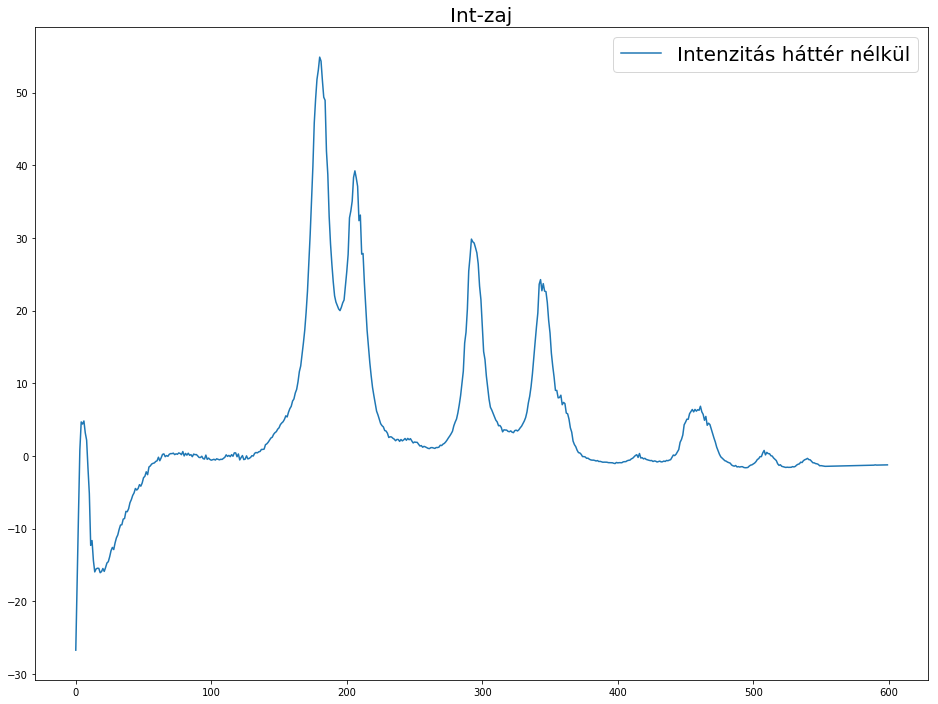

In [9]:
#az intenzitás a zaj levonása után:
plot(r, intensity - cauchy(r, *popt1), 'Intenzitás háttér nélkül', 'Int-zaj')

A $fitQuality$  bemeneti paramétere, $lambdaL$, a mikroskópállandó $pixel\times Angström$ egységekben. A $fitQuality$ kiszámítja, hogy adott $lambdaL$ esetén az első néhány gyűrűnek hol kéne lennie a képen. Ezek után összeszorozza a kiszámított helyeken mért intenzitásokat, és ezt adja vissza. Ha a kiszámított gyűrűk helye megegyezik a képen látható gyűrűk pozíciójával, akkor a visszaadott érték maximális lesz.

Végül a $fitQuality$ értékét ábrázoltam a $lambdaL$ függvényében.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


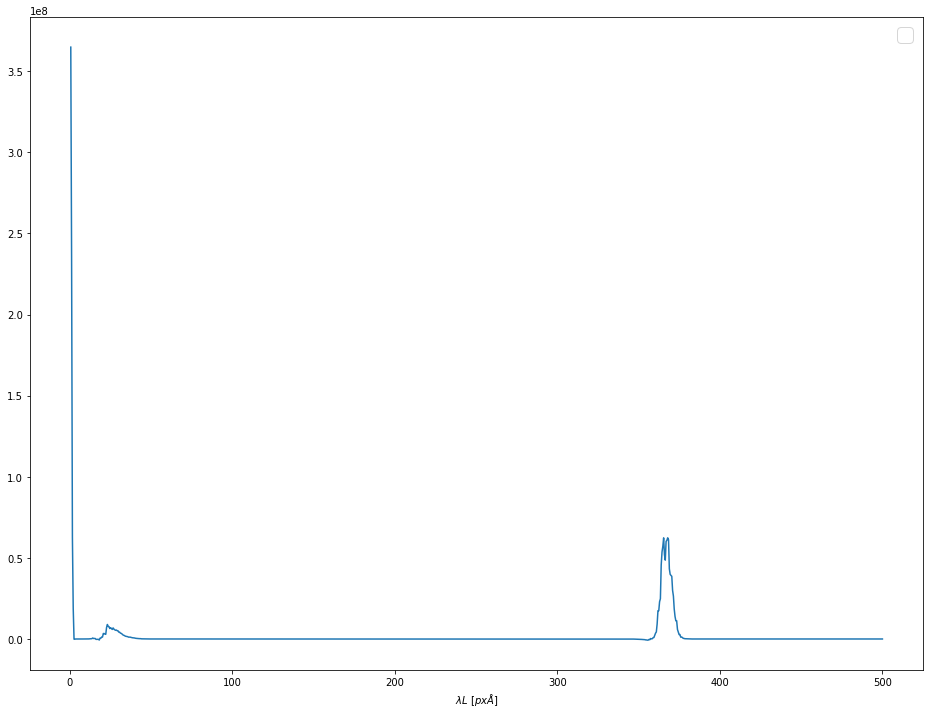

In [10]:
d = np.array([2.037180, 1.764250, 1.247510, 1.063880, 1.018590, 0.809493])

def fitQuality(lambdaL):
    result = lambdaL / lambdaL
    for currentd in d:
        r = np.clip((lambdaL / currentd).astype(int), 0, Rrange - 1)
        result *= intensity[r] - cauchy(r, *popt1)
    return result

scalerange = np.linspace(0, 500, 1000)
plot(scalerange, fitQuality(scalerange))
plt.xlabel("$\lambda L$ [$px\AA$]")
scalerange = np.linspace(330, 400, 1000)

Az így kapott görbe csúcsának a helye határozza meg a méréshez tartozó $lambdaL$ értékét. A csúcs meghatározásához egy gauss görbét illesztettem a függvényre, és annak a csúcsának a helyét használtam a továbiakban.

scale =  367.0477664973271


Text(0.5, 87.0, '$\\lambda L$ [$px\\AA$]')

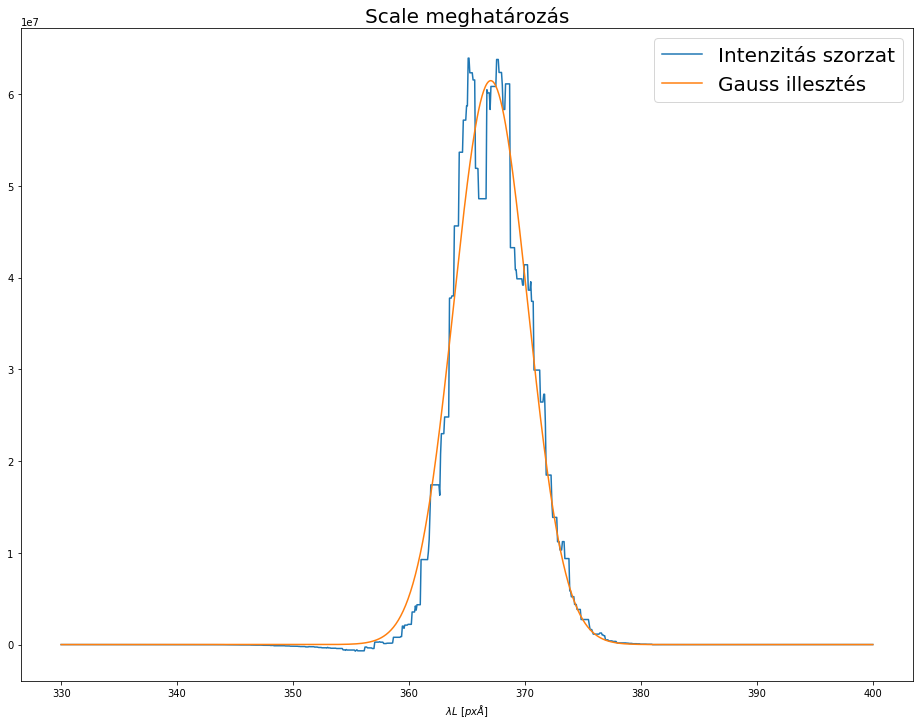

In [11]:
popt2, pcov2 = curve_fit(gauss, scalerange, fitQuality(scalerange), 
                         p0 = [6e7, 20, 350])
plot([scalerange, scalerange], 
     [fitQuality(scalerange), gauss(scalerange, *popt2)],
     ['Intenzitás szorzat', 'Gauss illesztés'], 'Scale meghatározás')

scale = popt2[2]
dscale = np.sqrt(pcov2[2, 2])
print("scale = ", scale)
plt.xlabel("$\\lambda L$ [$px\AA$]")

Text(0.5, 87.0, '$r$ [$px$]')

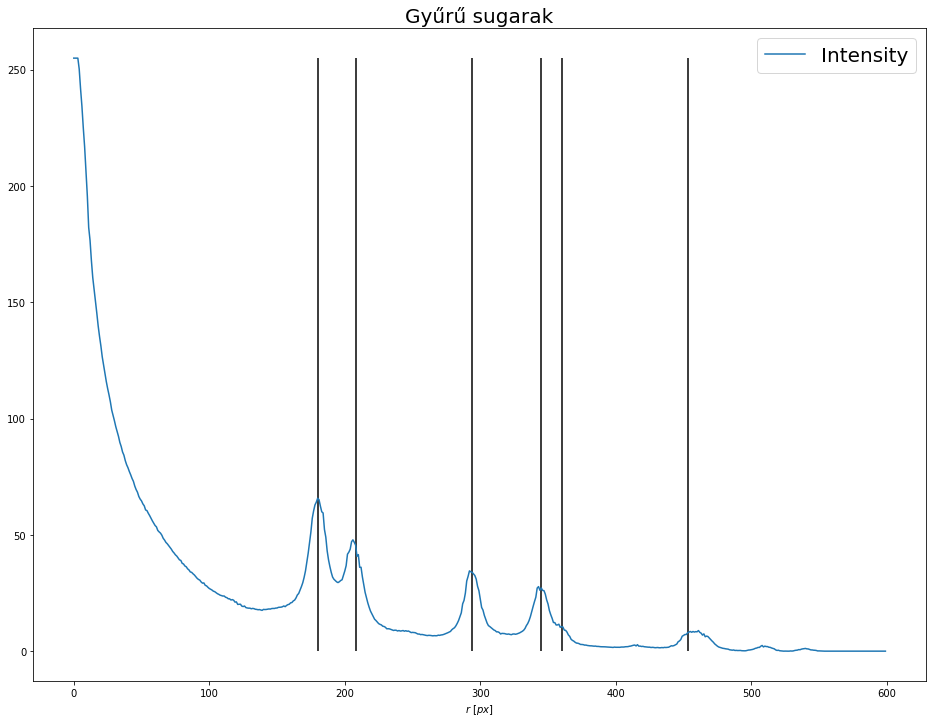

In [12]:
#a kiszámított scale alapján az elméleti és mért adatok összevetése
plot(r, intensity, 
     'Intensity', 'Gyűrű sugarak', vlines = scale / d)
plt.xlabel("$r$ [$px$]")

Az első néhány diffrakciós gyűrűt rárajzoltam az eredeti képre a kiszámított $scale$ és középpont szerint.

[ 3  4  8 11 12 16 19 20 24 27 27 32 35 36 36]


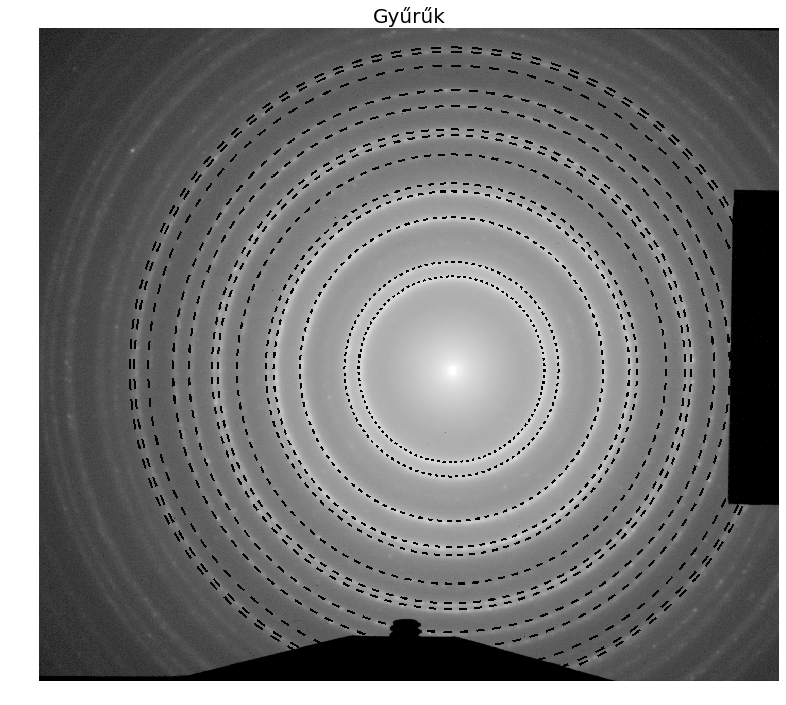

In [13]:
hkl = np.array(
    [[1, 1, 1], [2, 0, 0], [2, 2, 0], [3, 1, 1], [2, 2, 2],
     [4, 0, 0], [3, 3, 1], [4, 2, 0], [4, 2, 2], [5, 1, 1],
     [3, 3, 3], [4, 4, 0], [5, 3, 1], [4, 4, 2], [6, 0, 0]])

print(hkl[:, 0] * hkl[:, 0] + 
      hkl[:, 1] * hkl[:, 1] + 
      hkl[:, 2] * hkl[:, 2])
a = 3.5285
dplus = a / np.sqrt(hkl[:, 0] * hkl[:, 0] + hkl[:, 1] * hkl[:, 1] + hkl[:, 2] * hkl[:, 2])
Rhkl = scale / dplus

finalimage = np.copy(inverted)
for x in range(xlim):
    dr = 2
    N = 200
    mask = np.zeros(ylim, dtype = bool)
    for r in Rhkl:
        y = np.linspace(0, ylim-1, ylim).astype(int)
        tempmask = np.abs(np.sqrt((x-x0)**2 + (y - y0)**2) - r) < dr
        mask = np.logical_or(mask, tempmask)
    angle = np.arctan2(x - x0, y - y0)
    black = np.mod((angle / 2 / np.pi * N), 2) < 1
    finalimage[x, np.logical_and(mask, black)] = 0

imshow(finalimage, 'Gyűrűk')

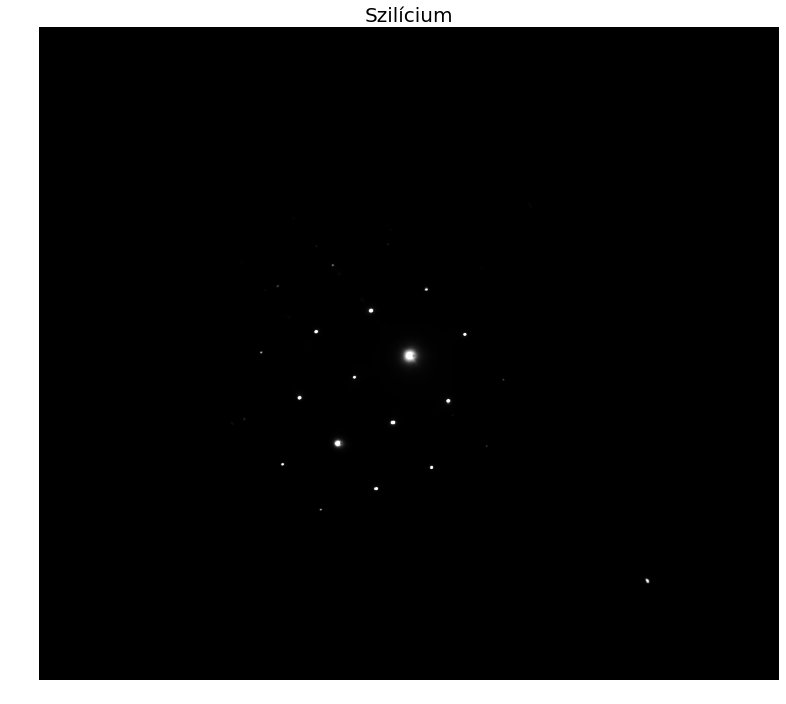

In [14]:
Si = mpimg.imread('data/Si.tif')

processedSi = np.copy(255-Si)

#kontraszt növelése
processedSi = (np.clip(processedSi/255, 0, 1))**(2) * 255
imshow(processedSi, "Szilícium")
#zaj levágása
processedSi = processedSi * (processedSi > 1)

A következő néhány segédfüggvé a szilícium adatait dolgozza fel. Az első függvénynek meg kell adni egy kezdeti pontot. A kezdeti pont körüli R sugarú körben kiszámolja az intenzitással súlyozott pixel pozíciók átlagát.


A második függvény iteratívan meghívja az elsőt, mindig az új középponttal. Ha két egymást követő függvényhívás által visszaadott középpontok között a $tolerance$-nál kisebb távolság van, a ciklus megszakad és visszatér a függvény az utolsó középponttal.


Az utolsó függvényt a meghatározott pontok bejelölésére használom.

In [15]:
def centerOfMass(img, x0, y0, R):
    dy = np.arange(-R, R + 1, 1)
    weight = 0
    deltax = deltay = 0
    x1 = y1 = 0
    for dx in range(-R, R + 1):
        mask = (dy**2 + dx**2) < R**2
        
        ysum = np.sum(mask * img[int(x0 + dx + 0.5), 
                                 int(y0 - R + 0.5): int(y0 + R + 1 + 0.5)])
        weight += ysum
        deltay += np.sum(mask * img[int(x0 + dx + 0.5), 
                                    int(y0 - R + 0.5): int(y0 + R + 1 + 0.5)] * dy)
        deltax += dx * ysum
    deltax /= weight
    deltay /= weight
    return x0 + deltax, y0 + deltay

def searchCenter(img, x0, y0, R, tolerance):
    x = x0
    y = y0
    oldx = oldy = 0
    while True:
        oldx = x
        oldy = y
        x, y = centerOfMass(img, x, y, R)
        dx = x - oldx
        dy = y - oldy
        if dx**2 + dy**2 < tolerance**2:
            break
    return x, y

def highlitePoint(img, x0, y0, R, color):
    W = 2 #line width
    
    #x line
    y = (np.arange(y0 - R, y0 + R, 1) + 0.5).astype(int)
    for x in (np.arange(x0 - W/2, x0 + W/2, 1) + 0.5).astype(int):
        img[x, y] = color
    
    #y line
    x = (np.arange(x0 - R, x0 + R, 1) + 0.5).astype(int)
    for y in (np.arange(y0 - W/2, y0 + W/2, 1) + 0.5).astype(int):
        img[x, y] = color
        
    return

A következő részben négy pontot keresek meg. Kiválasztok egy közeli kezdőpontot és megfelelő keresési sugarat, majd a fenti függvények pontosan meghatározzák a középpontot. A meghatározott pont bejelöléséhez ugyan azt a sugarat használom, mint a keresésben. Ez alapján választottam ki a megfelelő sugárméreteket.

549.4252341241739 644.2447694557671


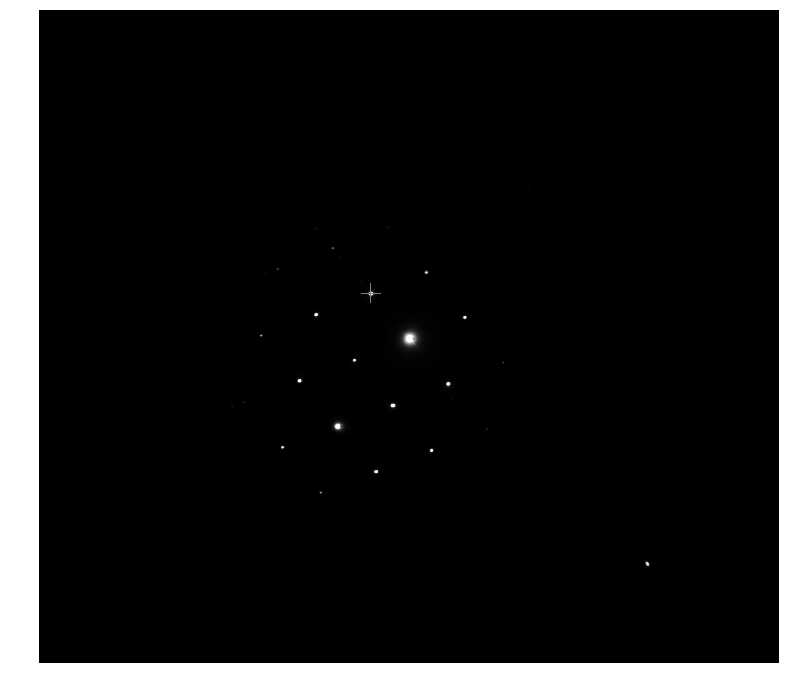

In [16]:
R1 = 20
color1 = 128
x1, y1 = searchCenter(processedSi, x0 = 570, y0 = 630, R = R1, tolerance = 0.5)
print(x1, y1)
markedSi = np.copy(processedSi)
highlitePoint(markedSi, x0 = x1, y0 = y1, R = R1, color = color1)
imshow(markedSi)

812.4184257249951 868.6552508713094


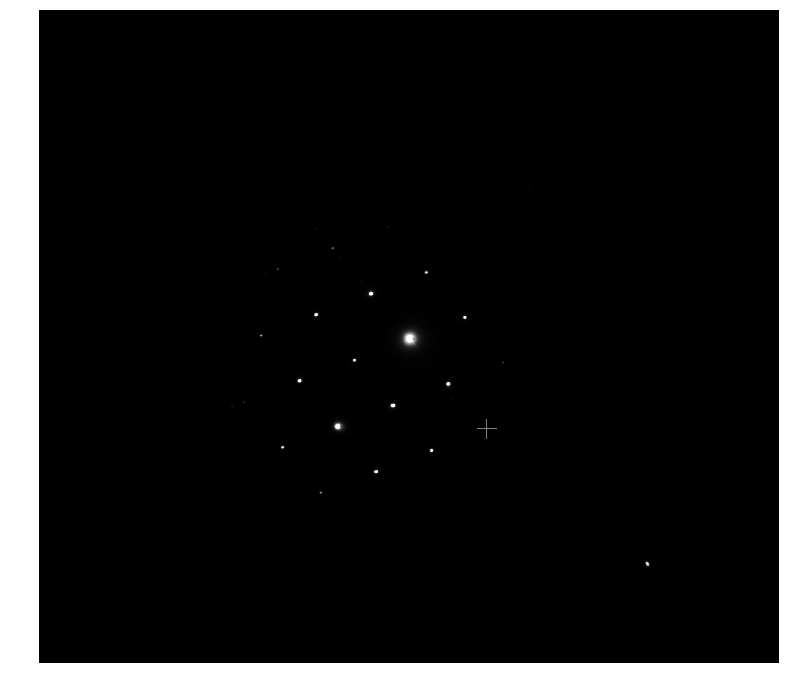

In [17]:
R2 = 20
color2 = 128
x2, y2 = searchCenter(processedSi, x0 = 800, y0 = 860, R = R2, tolerance = 0.5)
print(x2, y2)
markedSi = np.copy(processedSi)
highlitePoint(markedSi, x0 = x2, y0 = y2, R = R2, color = color2)
imshow(markedSi)

718.2215257418873 505.35623494817725


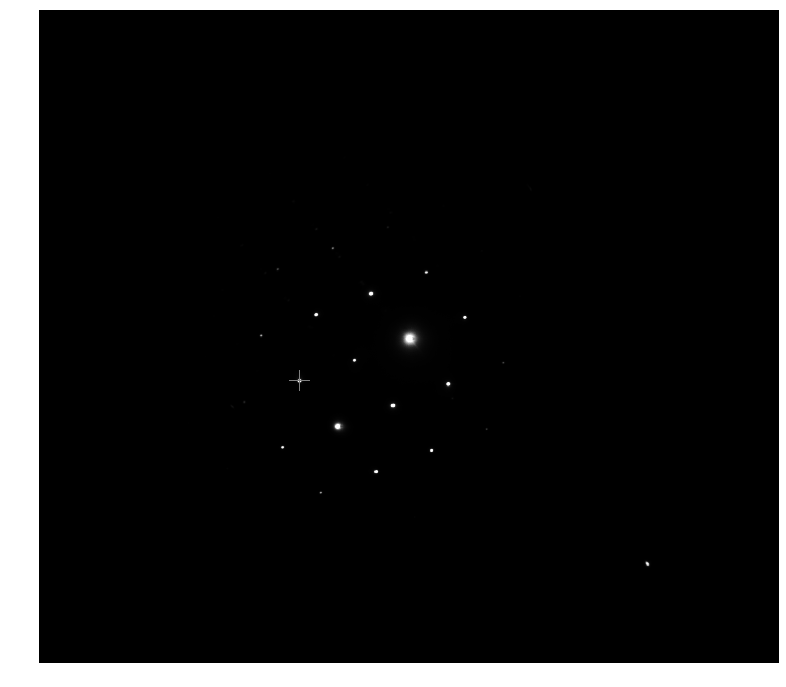

In [18]:
R3 = 20
color3 = 128
x3, y3 = searchCenter(processedSi, x0 = 730, y0 = 500, R = R3, tolerance = 1)
print(x3, y3)
markedSi = np.copy(processedSi)
highlitePoint(markedSi, x0 = x3, y0 = y3, R = R3, color = color3)
imshow(markedSi)

596.2146084780741 825.2577388790511


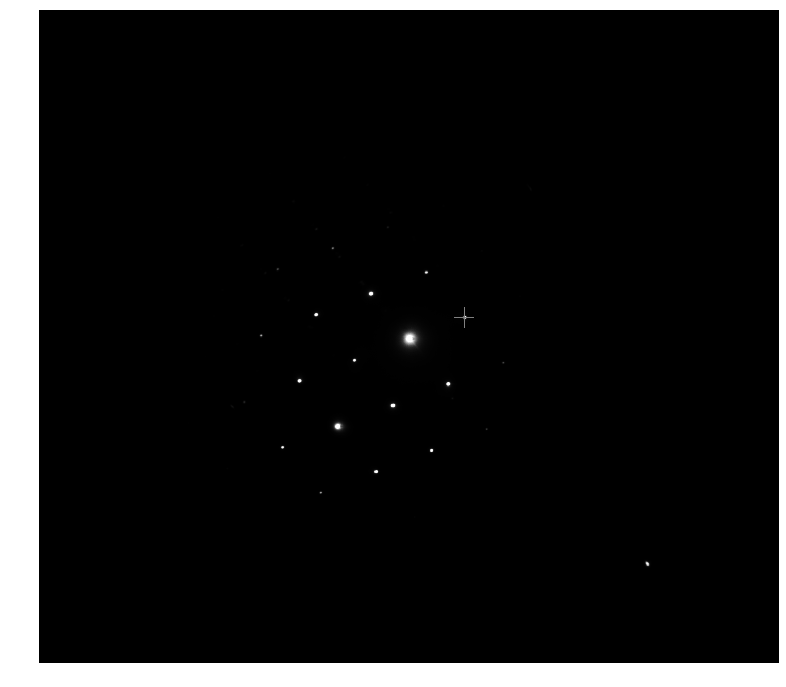

In [19]:
R4 = 20
color4 = 128
x4, y4 = searchCenter(processedSi, x0 = 580, y0 = 830, R = R4, tolerance = 1)
print(x4, y4)
markedSi = np.copy(processedSi)
highlitePoint(markedSi, x0 = x4, y0 = y4, R = R4, color = color4)
imshow(markedSi)

Végül mind a négy pontot egyszerre ábrázoltam az eredeti képen.

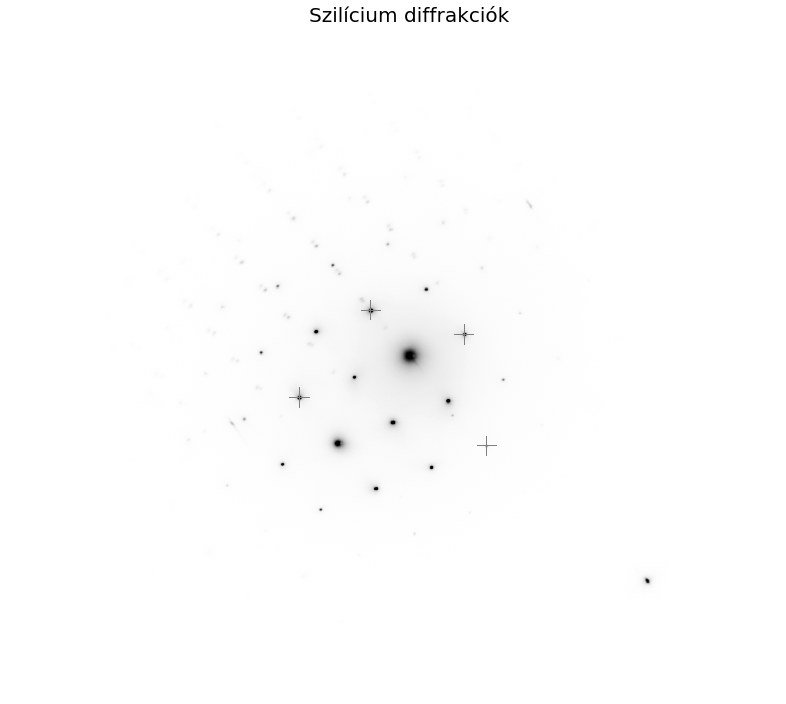

In [20]:
markedSi = np.copy(Si)
highlitePoint(markedSi, x0 = x1, y0 = y1, R = R1, color = 255 - color1)
highlitePoint(markedSi, x0 = x2, y0 = y2, R = R2, color = 255 - color2)
highlitePoint(markedSi, x0 = x3, y0 = y3, R = R3, color = 255 - color3)
highlitePoint(markedSi, x0 = x4, y0 = y4, R = R4, color = 255 - color4)
imshow(markedSi, "Szilícium diffrakciók")

A képen feketével bejelölt diffrakciók balról jobbra $k_1$, $k_2$ és $k_3$.

In [21]:
k0 = np.array([x1, y1])
k1 = np.array([x2, y2]) - k0
k2 = np.array([x3, y3]) - k0
k3 = np.array([x4, y4]) - k0

#sanity check
print(k1 - k2 - 2 * k3)

[0.61815128 1.27307708]


A vektorok megfelelő összege 1-2 pixelen belül megegyezik.

In [22]:
def pythagoras(k):
    if len(k.shape) == 1:
        k = np.array([k])
    return np.sqrt(k[:, 0]**2 + k[:, 1]**2)

ds = scale / pythagoras(np.array([k1, k2, k3]))

print(ds)
assumedds = np.array([1.045200, 1.637510, 1.920150])
print(ds/assumedds - 1)

scale /= np.average(ds / assumedds)
ds = scale / pythagoras(np.array([k1, k2, k3]))
print(ds/assumedds - 1)

[1.06167681 1.67914985 1.96321698]
[0.01576427 0.02542876 0.02242897]
[-0.00533003  0.00413376  0.00119626]


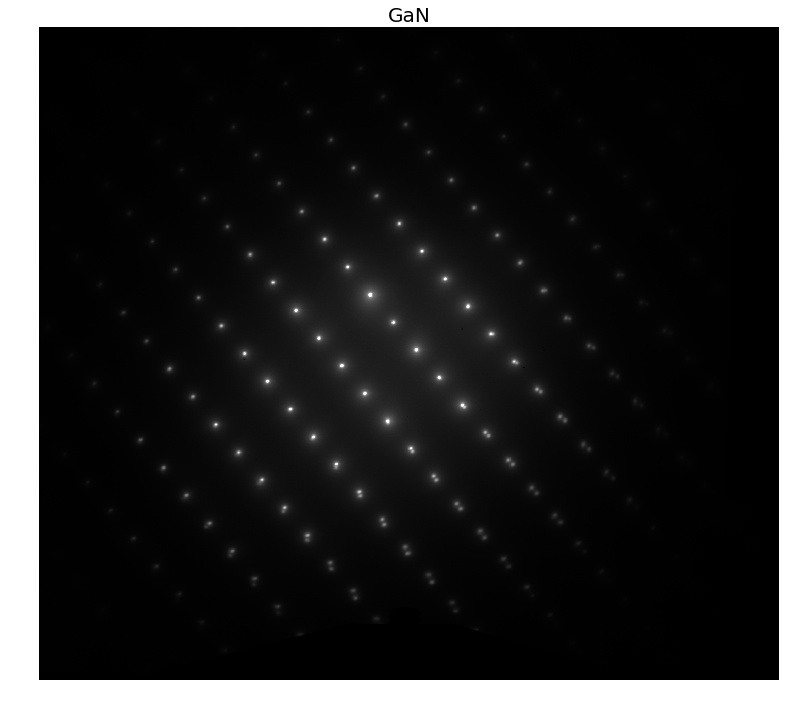

In [23]:
GaN = mpimg.imread('data/GaN.tif')

processedGaN = np.copy(255-GaN)

#kontraszt növelése
processedGaN = (np.clip(processedGaN/255, 0, 1))**(2) * 255
imshow(processedGaN, "GaN")
#zaj levágása
processedGaN = processedGaN * (processedGaN > 1)

382.28421120977185 698.6705053472988


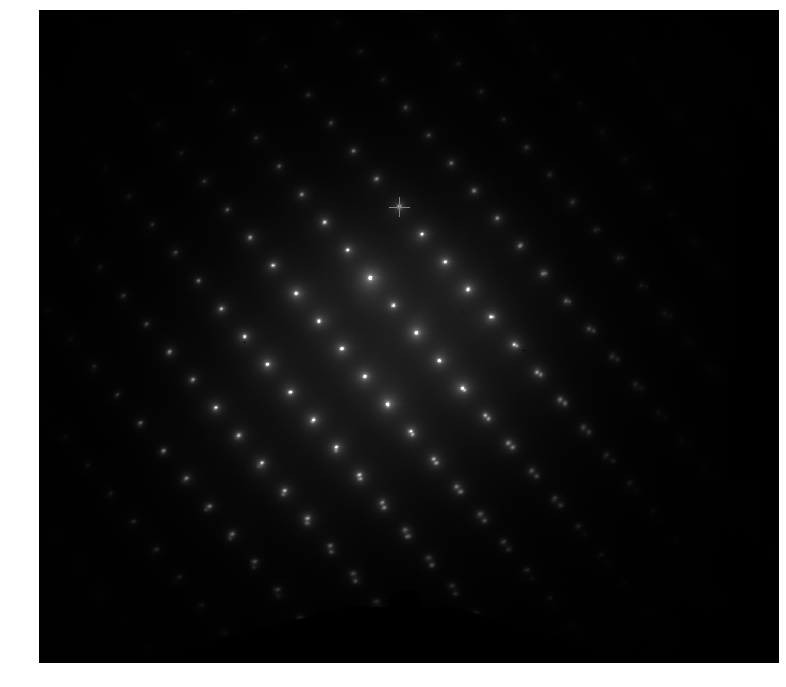

In [24]:
R1 = 20
color1 = 128
x1, y1 = searchCenter(processedGaN, x0 = 400, y0 = 650, R = R1, tolerance = 0.5)
print(x1, y1)
markedGaN = np.copy(processedGaN)
highlitePoint(markedGaN, x0 = x1, y0 = y1, R = R1, color = color1)
imshow(markedGaN)

594.4202346800442 876.129749846859


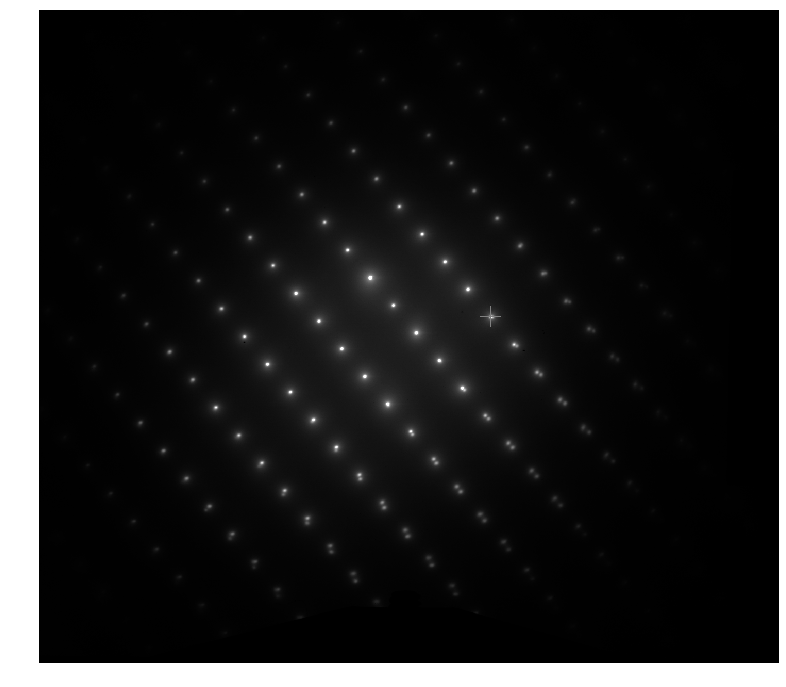

In [25]:
R1 = 20
color1 = 128
x2, y2 = searchCenter(processedGaN, x0 = 580, y0 = 870, R = R1, tolerance = 0.5)
print(x2, y2)
markedGaN = np.copy(processedGaN)
highlitePoint(markedGaN, x0 = x2, y0 = y2, R = R1, color = color1)
imshow(markedGaN)

549.480970395794 499.80555603562755


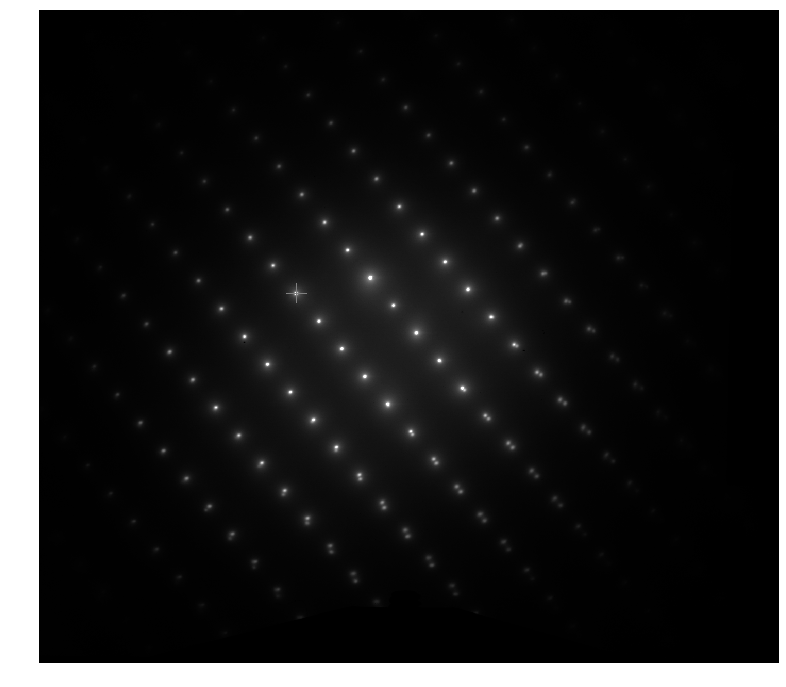

In [26]:
R1 = 20
color1 = 128
x3, y3 = searchCenter(processedGaN, x0 = 550, y0 = 520, R = R1, tolerance = 0.5)
print(x3, y3)
markedGaN = np.copy(processedGaN)
highlitePoint(markedGaN, x0 = x3 , y0 = y3, R = R1, color = color1)
imshow(markedGaN)

762.4806050802041 675.8306937483684


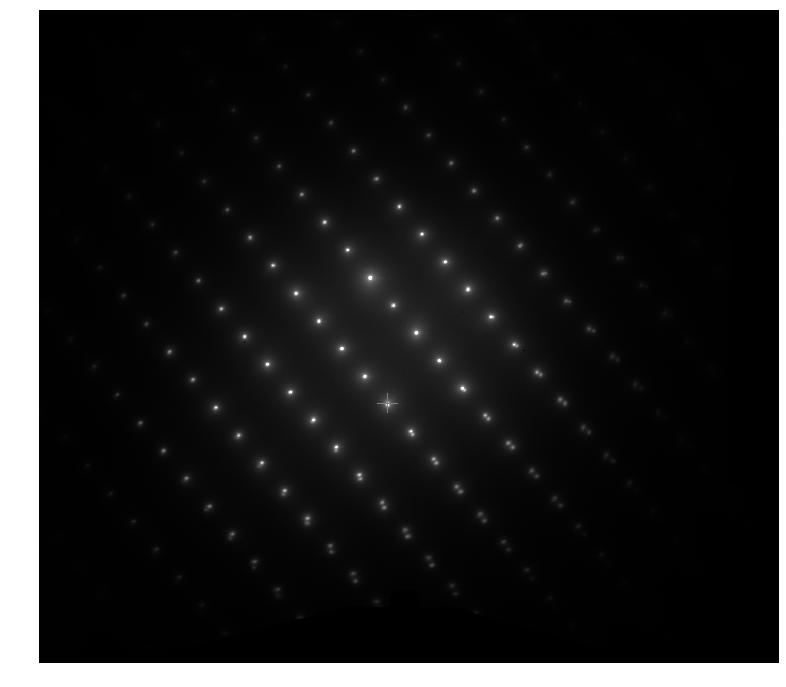

In [27]:
R1 = 20
color1 = 128
x4, y4 = searchCenter(processedGaN, x0 = 760, y0 = 670, R = R1, tolerance = 0.5)
print(x4, y4)
markedGaN = np.copy(processedGaN)
highlitePoint(markedGaN, x0 = x4, y0 = y4, R = R1, color = color1)
imshow(markedGaN)

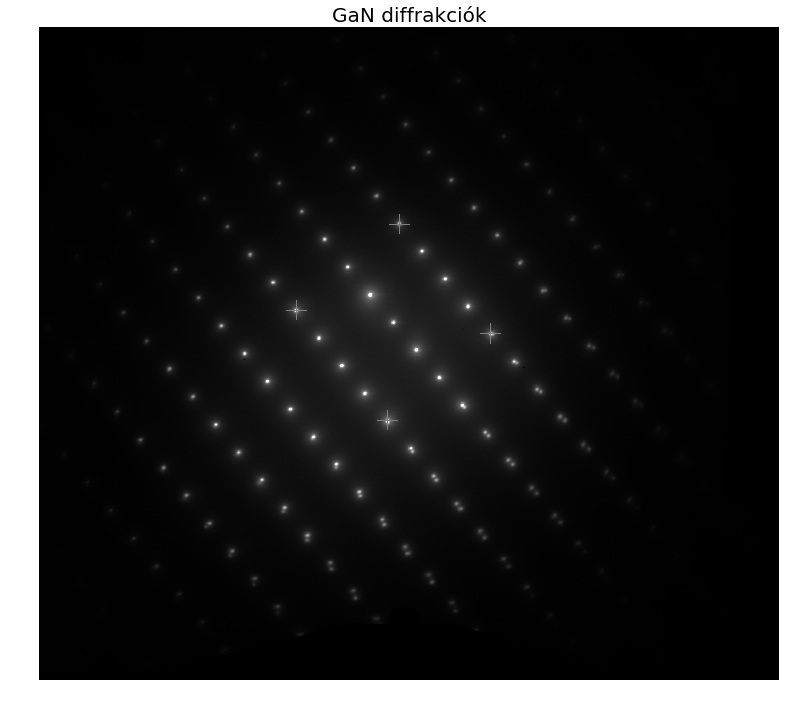

In [28]:
markedSi = np.copy(GaN)
highlitePoint(markedGaN, x0 = x1, y0 = y1, R = R1, color = 255 - color1)
highlitePoint(markedGaN, x0 = x2, y0 = y2, R = R2, color = 255 - color2)
highlitePoint(markedGaN, x0 = x3, y0 = y3, R = R3, color = 255 - color3)
highlitePoint(markedGaN, x0 = x4, y0 = y4, R = R4, color = 255 - color4)
imshow(markedGaN, "GaN diffrakciók")

In [29]:
k0 = np.array([x1, y1])
k1 = np.array([x2, y2]) - k0
k2 = np.array([x3, y3]) - k0
k3 = np.array([x4, y4]) - k0

#sanity check
print(k1 + k2 - k3)

[-0.86361121  1.43410679]


In [30]:
ds = scale / pythagoras(np.array([k1, k2, k3]))

print(ds)
assumedds = np.array([1.295, 1.382, 0.94])
print(ds/assumedds - 1)

[1.29956038 1.38340794 0.94366626]
[0.00352153 0.00101877 0.00390028]
